In [140]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
import os
from rasterio.plot import show

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [141]:
from pysal.lib import weights

In [142]:
#%pwd
#!pip install -U statsmodels
#!pip uninstall statsmodels
#!pip install pysal

In [143]:
gdf = gpd.read_file("./shapefiles(1)/cuencas_10km_2/basins.shp")
gdf_2 = gpd.read_file("./shapefiles(1)/cuencas_bigonly/basins.shp")

gdf

,ID,river_mouth,center_x,center_y,drainage_ar,outlet_elev,mean_el,max_el,mean_ksn,mean_gradie,se_el,se_ksn,se_gradient,hyp_int,theta,chi_r2,geometry
0,1,116,683796.297323,1153812.125,7050.714371,47,830.366821,5455,146.530962,0.278880,0.573481,2.780130,0.000165,0.147496,-2.057715,0.150485,"POLYGON ((627774.786 1125987.125, 627774.786 1..."
1,2,88,611100.824097,1127462.125,3125.340756,49,424.304962,3087,61.608111,0.162330,0.451407,2.033246,0.000175,0.127100,-4.060059,0.474727,"POLYGON ((574878.080 1126087.125, 574878.080 1..."
2,3,208,732743.249377,1207562.125,2707.912744,67,590.305908,4239,125.621644,0.222867,0.542782,10.806887,0.000204,0.163848,-2.418750,0.217524,"POLYGON ((676121.775 1207787.125, 676121.775 1..."
3,4,15,619450.304172,1170162.125,2283.728074,1,1560.150879,5697,234.432055,0.328857,1.526268,7.487155,0.000276,0.276909,-0.682813,0.445816,"POLYGON ((572328.238 1183137.125, 572328.238 1..."
4,5,16,619500.301059,1170162.125,2283.658083,1,1560.198730,5697,234.440722,0.328866,1.526288,7.487046,0.000276,0.276917,-0.682324,0.447966,"POLYGON ((572328.238 1183137.125, 572328.238 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009,3010,20067,622500.114259,1177612.125,2.227223,936,1293.450073,1911,201.245680,0.434032,6.701403,80.129652,0.006644,0.370291,0.354004,0.974986,"POLYGON ((621625.169 1178037.125, 621625.169 1..."
3010,3011,38001,585802.399440,1206612.125,2.192227,6,8.367161,14,6.540550,0.018930,0.074951,6.427446,0.000407,0.603815,-1.622070,-0.083884,"POLYGON ((584777.463 1206537.125, 584777.463 1..."
3011,3012,39001,585802.399440,1206612.125,2.192227,6,8.367161,14,6.562540,0.018930,0.074951,6.436426,0.000407,0.603815,-1.607422,-0.084127,"POLYGON ((584777.463 1206537.125, 584777.463 1..."
3012,3013,45001,585802.399440,1206612.125,2.192227,6,8.367161,14,6.603076,0.018930,0.074951,6.452978,0.000407,0.603815,-1.580957,-0.084546,"POLYGON ((584777.463 1206537.125, 584777.463 1..."


<AxesSubplot:>

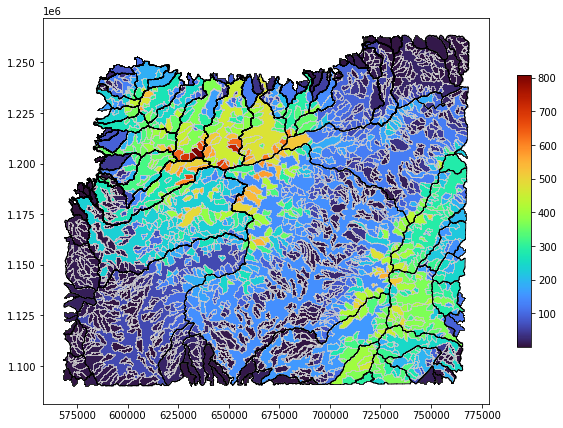

In [121]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
gdf.plot(column='mean_ksn', cmap='turbo', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,     legend_kwds={
        "shrink":.5
    })
gdf_2.boundary.plot(ax=ax, linewidth=0.8, edgecolor='black')


In [135]:
# Preparar datos
gdf['y_log'] = np.log(gdf['mean_ksn']+1)
var = ['mean_gradie', 'drainage_ar']

# Escalar variables
st = StandardScaler()
X_scaled = st.fit_transform(gdf[var])

# Añadir una constante par el término de intercepción en el modelo
X = sm.add_constant(X_scaled)
y = gdf['y_log']

# Entrenar el modelo de regresion lineal
model = sm.OLS(y,X).fit()

# Imprimir un resumen del modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  y_log   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     9236.
Date:                Wed, 25 Jun 2025   Prob (F-statistic):               0.00
Time:                        05:40:23   Log-Likelihood:                -2681.9
No. Observations:                3014   AIC:                             5370.
Df Residuals:                    3011   BIC:                             5388.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4184      0.011    411.537      0.0

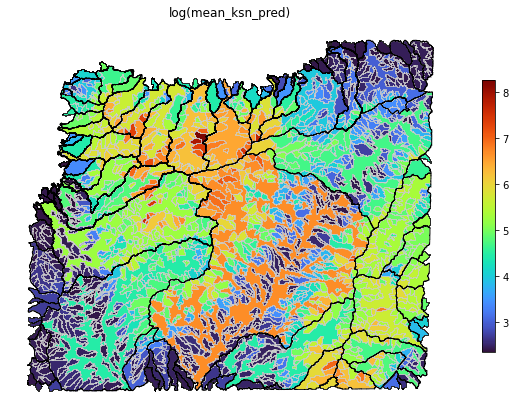

In [136]:
# Obtener las predicciones
y_pred = model.predict(X)

# Añadir las predicciones al GeoDataFrame
gdf['y_pred'] = y_pred

# Graficar el mapa con los valores de predicción
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='y_pred', cmap='turbo', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={
        "shrink":.5})
gdf_2.boundary.plot(ax=ax, linewidth=0.8, edgecolor='black')
ax.set_title('log(mean_ksn_pred)')
ax.set_axis_off()
plt.show()


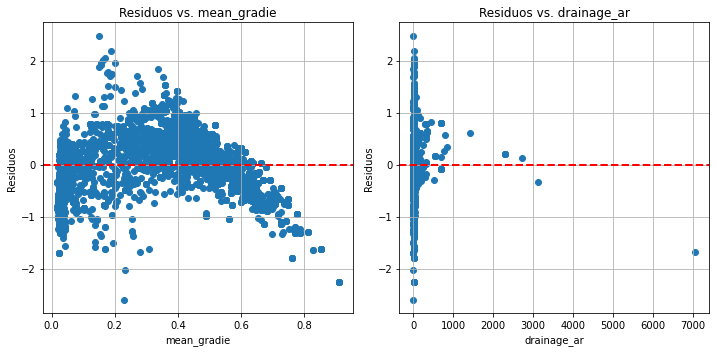

In [147]:
# Calcular los residuos
residuals = y - y_pred
# Añadir los residuales al dataframe
gdf['residuals'] = residuals

# Crear las figuras scatter para comparar los residuos con cada variable X
plt.figure(figsize=(15, 5))

for i, variable in enumerate(var):
    plt.subplot(1, 3, i + 1)
    plt.scatter(gdf[variable], residuals)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel(variable)
    plt.ylabel('Residuos')
    plt.title(f'Residuos vs. {variable}')
    plt.grid(True)

plt.tight_layout()
plt.show()


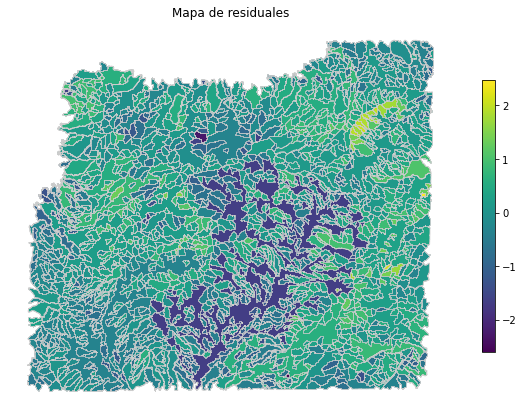

In [148]:


# Graficar el mapa con los valores de predicción
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='residuals', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={
        "shrink":.5})

ax.set_title('Mapa de residuales')
ax.set_axis_off()
plt.show()


(array([1178.,  400.,  392.,  354.,  317.,  170.,   93.,   60.,   36.,
          14.]),
 array([  1.013461,  81.821167, 162.628873, 243.436579, 324.244285,
        405.051991, 485.859697, 566.667403, 647.475109, 728.282815,
        809.090521]),
 <BarContainer object of 10 artists>)

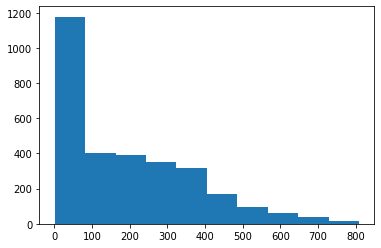

In [149]:
# esploración de los datos
plt.hist(gdf['mean_ksn'])

In [150]:
knn = weights.KNN.from_dataframe(gdf, k=5)

/home/miguel/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 137 disconnected components.
  warnings.warn(message)


(array([  6.,  10.,  49., 226., 608., 921., 758., 364.,  66.,   6.]),
 array([-11.33230848,  -9.32197295,  -7.31163742,  -5.30130188,
         -3.29096635,  -1.28063081,   0.72970472,   2.74004025,
          4.75037579,   6.76071132,   8.77104686]),
 <BarContainer object of 10 artists>)

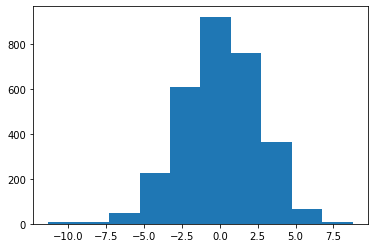

In [151]:
spatial_lag = weights.spatial_lag.lag_spatial(knn,gdf['residuals'])
plt.hist(spatial_lag)

In [129]:
## Procedemos a realizar el rezago espacial
#gdf['rezago'] = weights.lag_spatial(w, gdf['mean_ksn'])

#gdf[['mean_ksn','rezago']].head()



# Estandarizamos para mena_ksn restando el valor promedio y dividiendo por la desviacion estandar
#gdf['mean_ksn_std'] = (gdf['mean_ksn'] - gdf['mean_ksn'].mean())/ gdf['mean_ksn'].std()

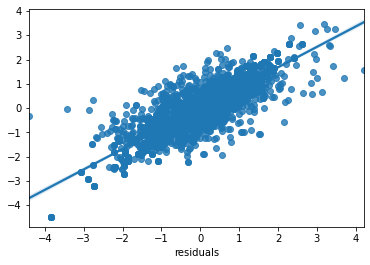

In [152]:
import seaborn
x = (gdf['residuals']-gdf['residuals'].mean())/gdf['residuals'].std()
y=(spatial_lag.flatten()-spatial_lag.flatten().mean()) / spatial_lag.flatten().std()

ax = seaborn.regplot(x=(gdf['residuals']-gdf['residuals'].mean())/gdf['residuals'].std(), y=y)

In [87]:
#gdf['w_mean_ksn_std'] = weights.lag_spatial(w, gdf['mean_ksn_std'])
gdf['spatial_lag'] = (gdf['rezago'] - gdf['rezago'].mean())/gdf['rezago'].std()

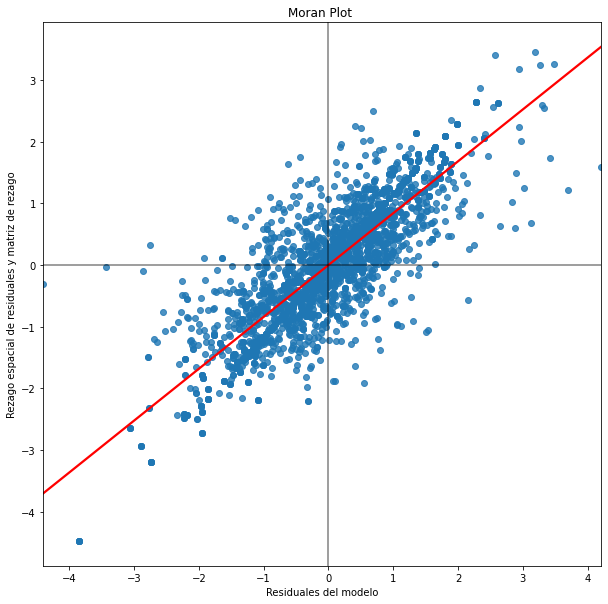

In [155]:

f, ax = plt.subplots(1, figsize=(10, 10))
sbn.regplot(x=x, y=y,ci=None, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot ')
ax.set_ylabel('Rezago espacial de residuales y matriz de rezago')
ax.set_xlabel('Residuales del modelo')
plt.show()